In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import imutils
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
mpl.rcParams['image.cmap'] = 'gray'
from scipy import spatial, sparse
from sklearn.metrics.pairwise import cosine_similarity
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

import array

font = cv2.FONT_HERSHEY_COMPLEX
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

[[114, 247, 158, 48],
 [118, 250, 151, 42],
 [118, 439, 151, 42],
 [118, 377, 151, 42],
 [575, 332, 93, 56],
 [416, 332, 93, 56],
 [118, 311, 151, 42],
 [769, 170, 93, 56],
 [575, 170, 93, 56],
 [416, 170, 93, 56],
 [575, 8, 93, 56],
 [413, 5, 99, 62],
 [416, 8, 93, 56]]

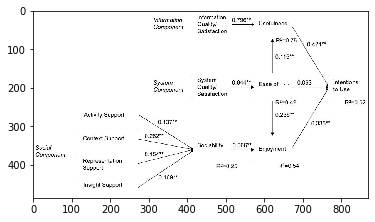

In [32]:
#specify relative path to model images
imagedir = 'Input Model/'

#list of all images
models = os.listdir(imagedir)

file = imagedir + models[1]

img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
_, threshold = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

shapes = []
#list of four corners of the shapes
shapes_corners = []
#list of four midpoints for each line of the shapes 
shapes_midpoints = []

for c in contours[1:]:
    x, y, w, h = cv2.boundingRect(c)
    if (h > 30) and (w > 30) and (h < 150) and (w < 200):
        cv2.drawContours(img, [c], 0, (255, 0, 0), 5)
        shapes.append([x,y,w,h])
        #Identify four corners of the shapes 
        a = np.array([x,y])
        b = np.array([x+w,y])
        c = np.array([x,y+h])
        d = np.array([x+w,y+h])
        shapes_corners.append(np.array([a,c,d,b]))
        #Identifiy four midpoints of the shapes
        shapes_midpoints.append([[a+(b-a)/2],[a+(c-a)/2],[b+(d-b)/2],[c+(d-c)/2]])

plt.imshow(img)

cv2.imwrite('img.png', img)

shapes


True

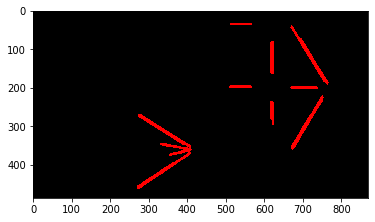

In [35]:
#First, get the gray image and process GaussianBlur.

img = cv2.imread('img.png')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)


kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

#Second, process edge detection use Canny.

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

#Then, use HoughLinesP to get the lines. You can adjust the parameters for better performance.

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap =  1 # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

arrows = list()

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        arrows.append([np.array([x1,y1]),np.array([x2,y2])])


# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

plt.imshow(line_image)
cv2.imwrite('img_lines.png', line_image)
#arrows


[[array([271, 457], dtype=int32), array([364, 396], dtype=int32)],
 [array([670, 356], dtype=int32), array([720, 273], dtype=int32)],
 [array([275, 270], dtype=int32), array([408, 353], dtype=int32)],
 [array([332, 346], dtype=int32), array([408, 360], dtype=int32)],
 [array([670, 200], dtype=int32), array([736, 200], dtype=int32)],
 [array([673, 357], dtype=int32), array([749, 231], dtype=int32)],
 [array([354, 374], dtype=int32), array([404, 362], dtype=int32)],
 [array([622, 162], dtype=int32), array([622,  82], dtype=int32)],
 [array([511, 198], dtype=int32), array([565, 198], dtype=int32)],
 [array([275, 273], dtype=int32), array([392, 346], dtype=int32)],
 [array([694,  75], dtype=int32), array([763, 189], dtype=int32)],
 [array([670,  43], dtype=int32), array([745, 164], dtype=int32)],
 [array([619, 162], dtype=int32), array([619,  82], dtype=int32)],
 [array([514,  36], dtype=int32), array([566,  36], dtype=int32)],
 [array([272, 460], dtype=int32), array([406, 370], dtype=int3

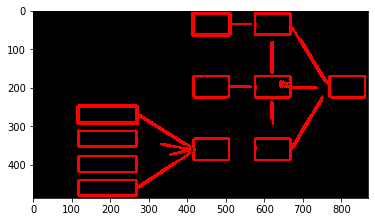

In [37]:
line_image = np.copy(img) * 0  # creating a blank to draw lines on

class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

def ccw(A,B,C):
    return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

def is_intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)



#draw shapes into image  
for c in contours[1:]:
    x, y, w, h = cv2.boundingRect(c)
    if (h > 30) and (w > 30) and (h < 150) and (w < 200):
        cv2.drawContours(line_image, [c],0,(255, 0, 0), 5)


intersect_arrows = list()
        
for h in range(len(arrows)):
    x1 = arrows[h][0][0]
    y1 = arrows[h][0][1]
    x2 = arrows[h][1][0]
    y2 = arrows[h][1][1]
    intersect = False
    for j in range(len(shapes_corners)):
        edges = []
        edges.append(np.array([shapes_corners[j][0],shapes_corners[j][1]]))
        edges.append(np.array([shapes_corners[j][0],shapes_corners[j][2]]))
        edges.append(np.array([shapes_corners[j][1],shapes_corners[j][3]]))
        edges.append(np.array([shapes_corners[j][2],shapes_corners[j][3]]))
        for e in edges:
            a = Point(e[0][0],e[0][1])
            b = Point(e[1][0],e[1][1])
            # scale up lines by 2
            c = Point(x1-(x2-x1),y1-(y2-y1))
            d = Point(x2+(x2-x1),y2+(y2-y1))
            # check if 
            if is_intersect(a,b,c,d) == True:
                intersect = True
                #cv2.line(line_image,(e[0][0], e[0][1]), (e[1][0],e[1][1]),(255,0,0),5)
            
    if intersect == True:
        #cv2.line(line_image,(x1-(x2-x1),y1-(y2-y1)),(x2+(x2-x1),y2+(y2-y1)),(255,0,0),5)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        intersect_arrows.append([np.array([x1,y1]),np.array([x2,y2])])
        
plt.imshow(line_image)
cv2.imwrite('img_lines_shapes.png', line_image)

intersect_arrows


In [38]:
# keep only one detected arrow per line --> by comparing the slope
intersect_arrows_final = list()

# slope of line 
def slope(x1, y1, x2, y2): 
    return (float)(y2-y1)/(x2-x1)

def check(list, s): 
    for x in list: 
        if abs(s-x)<0.1: 
            return False 
    return True

slp_list = []

for ar in intersect_arrows:
    x1 = ar[0][0]
    y1 = ar[0][1]
    x2 = ar[1][0]
    y2 = ar[1][1]
    slp = slope(x1,y1,x2,y2)
    if check(slp_list,slp):
        intersect_arrows_final.append([np.array([x1,y1]),np.array([x2,y2])])
    slp_list.append(slp)

intersect_arrows_final

c:\users\merzg\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\merzg\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


[[array([271, 457], dtype=int32), array([364, 396], dtype=int32)],
 [array([670, 356], dtype=int32), array([720, 273], dtype=int32)],
 [array([275, 270], dtype=int32), array([408, 353], dtype=int32)],
 [array([332, 346], dtype=int32), array([408, 360], dtype=int32)],
 [array([670, 200], dtype=int32), array([736, 200], dtype=int32)],
 [array([354, 374], dtype=int32), array([404, 362], dtype=int32)],
 [array([622, 162], dtype=int32), array([622,  82], dtype=int32)],
 [array([694,  75], dtype=int32), array([763, 189], dtype=int32)],
 [array([619, 162], dtype=int32), array([619,  82], dtype=int32)],
 [array([619, 236], dtype=int32), array([619, 282], dtype=int32)],
 [array([622, 295], dtype=int32), array([622, 240], dtype=int32)]]

In [39]:
# check with how many arrows each shape intersects
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

def ccw(A,B,C):
    return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

def is_intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

intersects = []

for j in range(len(shapes_corners)):
    intersect_counter = 0
    edges = []
    edges.append(np.array([shapes_corners[j][0],shapes_corners[j][1]]))
    edges.append(np.array([shapes_corners[j][0],shapes_corners[j][2]]))
    edges.append(np.array([shapes_corners[j][1],shapes_corners[j][3]]))
    edges.append(np.array([shapes_corners[j][2],shapes_corners[j][3]]))
    
    print('Shape Nr: '+str(j))
    print(edges)
    
    for h in range(len(intersect_arrows_final)):
        x1 = intersect_arrows_final[h][0][0]
        y1 = intersect_arrows_final[h][0][1]
        x2 = intersect_arrows_final[h][1][0]
        y2 = intersect_arrows_final[h][1][1]
        for e in edges:
            a = Point(e[0][0],e[0][1])
            b = Point(e[1][0],e[1][1])
            # scale up lines by 2
            c = Point(x1-(x2-x1),y1-(y2-y1))
            d = Point(x2+(x2-x1),y2+(y2-y1))
            # check if arrow intersects with one line --> if yes, stop checking other lines
            if is_intersect(a,b,c,d) == True:
                intersect_counter +=1
                break
    intersects.append(intersect_counter)
    
    print('Number of Intersections: ' + str(intersect_counter))
    print('')
intersects

Shape Nr: 0
[array([[114, 247],
       [114, 295]]), array([[114, 247],
       [272, 295]]), array([[114, 295],
       [272, 247]]), array([[272, 295],
       [272, 247]])]
Number of Intersections: 1

Shape Nr: 1
[array([[118, 250],
       [118, 292]]), array([[118, 250],
       [269, 292]]), array([[118, 292],
       [269, 250]]), array([[269, 292],
       [269, 250]])]
Number of Intersections: 1

Shape Nr: 2
[array([[118, 439],
       [118, 481]]), array([[118, 439],
       [269, 481]]), array([[118, 481],
       [269, 439]]), array([[269, 481],
       [269, 439]])]
Number of Intersections: 1

Shape Nr: 3
[array([[118, 377],
       [118, 419]]), array([[118, 377],
       [269, 419]]), array([[118, 419],
       [269, 377]]), array([[269, 419],
       [269, 377]])]
Number of Intersections: 0

Shape Nr: 4
[array([[575, 332],
       [575, 388]]), array([[575, 332],
       [668, 388]]), array([[575, 388],
       [668, 332]]), array([[668, 388],
       [668, 332]])]
Number of Intersections

[1, 1, 1, 0, 1, 4, 1, 3, 5, 0, 3, 0, 0]

True

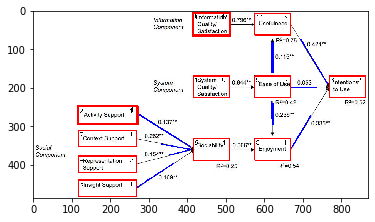

In [40]:
# Read initial image with color and mark detected shapes + arrows + number of intersections

img = cv2.imread(file)
cnt = 0

#draw shapes + shape nr.
for s in shapes_corners:
    cv2.drawContours(img, [s], 0, (255, 0, 0), 2)
    cv2.putText(img,str(cnt+1),(s[0][0]+2,s[0][1]+15), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    cv2.putText(img,str(intersects[cnt]),(s[3][0]-20,s[3][1]+15), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    cnt+=1

#draw arrows  
for ar in intersect_arrows_final:
    x1 = ar[0][0]
    y1 = ar[0][1]
    x2 = ar[1][0]
    y2 = ar[1][1]
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    
plt.imshow(img)
cv2.imwrite('final.png',img)